In [15]:
import pandas as pd
import numpy as np
import os
import glob

cwd = os.getcwd()
data_folder = os.path.join(cwd, "Data")
xpt_files = glob.glob(os.path.join(data_folder, "*.xpt"))

dfs = []
for file in xpt_files:
    df = pd.read_sas(file, format='xport')
    if 'SEQN' in df.columns:
        # Drop duplicate SEQN rows, keep first occurrence
        df = df.drop_duplicates(subset='SEQN')

        # Set SEQN as index
        df = df.set_index('SEQN')
        dfs.append(df)

# Concatenate along columns matching SEQN index
merged_df = pd.concat(dfs, axis=1, join='outer')

# Optional reset index for SEQN as column
merged_df = merged_df.reset_index()

print(merged_df.shape)

(11933, 547)


In [16]:
merged_df.columns

Index(['SEQN', 'ACD010A', 'ACD010B', 'ACD010C', 'ACD040', 'WTPH2YR', 'LBXAGP',
       'ALQ111', 'ALQ121', 'ALQ130',
       ...
       'URXPREG', 'WTPH2YR', 'LBXVIDMS', 'LBDVIDLC', 'LBXVD2MS', 'LBDVD2LC',
       'LBXVD3MS', 'LBDVD3LC', 'LBXVE3MS', 'LBDVE3LC'],
      dtype='object', length=547)

In [17]:

fnq_cols = [
     'FNQ021', 'FNQ041', 'FNQ050', 'FNQ060', 'FNQ080', 'FNQ160', 'FNQ100', 'FNQ110',
    'FNQ120', 'FNQ170', 'FNQ180', 'FNQ190', 'FNQ130', 'FNQ200', 'FNQ140', 'FNQ150', 'FNQ410',
    'FNQ430', 'FNQ440', 'FNQ450', 'FNQ460', 'FNQ470', 'FNQ480', 'FNQ490', 'FNQ510', 'FNQ520',
    'FNQ530', 'FNQ540'
]

# Create composite column reflecting max difficulty reported across all domains
merged_df[fnq_cols]

,FNQ021,FNQ041,FNQ050,FNQ060,FNQ080,FNQ160,FNQ100,FNQ110,FNQ120,FNQ170,...,FNQ440,FNQ450,FNQ460,FNQ470,FNQ480,FNQ490,FNQ510,FNQ520,FNQ530,FNQ540
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,5.0,NaN,5.0,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,5.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,1.0,1.0,1.0,1.0,1.0,4.0,3.0,4.0,1.0
3,1.0,1.0,2.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
merged_df["SystolicBP"]=(merged_df["BPXOSY1"]+merged_df["BPXOSY2"]+merged_df["BPXOSY3"])/3
merged_df["DiastolicBP"]=(merged_df["BPXODI1"]+merged_df["BPXODI2"]+merged_df["BPXODI3"])/3
merged_df["Pulse"]=(merged_df["BPXOPLS1"]+merged_df["BPXOPLS2"]+merged_df["BPXOPLS3"])/3
mrt_time_cols = [c for c in merged_df.columns if c.startswith("BAXTC")]
merged_df["MRT_Avg_Time"] = merged_df[mrt_time_cols].mean(axis=1)
# Create a composite metric as mean of body part measures (excluding missing values)
merged_df['BODY_MEASURE_COMPOSITE'] = merged_df[['BMXLEG', 'BMXARML', 'BMXARMC', 'BMXWAIST', 'BMXHIP']].mean(axis=1)

# Create combined column by summing ug/L values (handle missing values by skipping)
merged_df['blood_macros'] = merged_df[['LBXBCD', 'LBXTHG', 'LBXBSE', 'LBXBMN']].mean(axis=1, skipna=True)

merged_df['mean_steroid_ng_dl'] = merged_df[['LBX17H', 'LBXAND', 'LBXDHE', 'LBXESO', 'LBXPG4', 'LBXTST']].mean(axis=1, skipna=True)
#combine all balance composite columns
balance_cols = [
    'BAQ321A', 'BAQ321B', 'BAQ321C', 'BAQ321D', 'BAQ341', 
    'BAQ391A', 'BAQ391B', 'BAQ401', 'BAQ421', 'BAQ431', 
    'BAQ491', 'BAQ530', 'BAQ550', 'BAQ560'
]

# Function to combine categorical columns by taking first non-null value
def combine_categorical(row):
    for val in row:
        if pd.notna(val):
            return val
    return np.nan

# Apply the function along rows and create a new combined column
merged_df['balance_combined'] = merged_df[balance_cols].apply(combine_categorical, axis=1)

# Drop original individual columns
merged_df.drop(columns=balance_cols, inplace=True)

# Convert pounds to grams and ounces to grams, then sum
merged_df['birth_weight_grams'] = merged_df['ECD070A'] * 453.592 + merged_df['ECD070B'] * 28.3495

# Handle special codes (3 pounds or less coded as 3, 11 pounds or more coded as 11, etc.)
# You may want to replace or drop these values as appropriate
special_codes = [3, 11]
merged_df.loc[merged_df['ECD070A'].isin(special_codes), 'birth_weight_grams'] = np.nan

# Drop original columns after combining
cols_to_drop = ['ECD070A', 'ECD070B', 'ECQ080', 'ECQ090']
merged_df = merged_df.drop(columns=cols_to_drop)


fnq_cols = [
     'FNQ021', 'FNQ041', 'FNQ050', 'FNQ060', 'FNQ080', 'FNQ160', 'FNQ100', 'FNQ110',
    'FNQ120', 'FNQ170', 'FNQ180', 'FNQ190', 'FNQ130', 'FNQ200', 'FNQ140', 'FNQ150', 'FNQ410',
    'FNQ430', 'FNQ440', 'FNQ450', 'FNQ460', 'FNQ470', 'FNQ480', 'FNQ490', 'FNQ510', 'FNQ520',
    'FNQ530', 'FNQ540'
]

# Create composite column reflecting max difficulty reported across all domains
merged_df['functional_difficulty_composite'] = merged_df[fnq_cols].max(axis=1, skipna=True)

# Optionally drop original columns
merged_df = merged_df.drop(columns=fnq_cols)


dpq_cols = [
    'DPQ010', 'DPQ020', 'DPQ030', 'DPQ040', 'DPQ050',
    'DPQ060', 'DPQ070', 'DPQ080', 'DPQ090', 'DPQ100'
]

# Create composite depression rank as max reported symptom score
merged_df['depression_rank'] = merged_df[dpq_cols].max(axis=1, skipna=True)

# Optional: drop individual columns post aggregation
merged_df = merged_df.drop(columns=dpq_cols)


In [19]:
drop_cols = [
    'ORXGH', 'ORXGL', 'ORXH06', 'ORXH11', 'ORXH16', 'ORXH18', 'ORXH26', 'ORXH31', 'ORXH33', 'ORXH35', 'ORXH39', 'ORXH40', 'ORXH42', 'ORXH45', 'ORXH51', 'ORXH52', 'ORXH53',
    'ORXH54', 'ORXH55', 'ORXH56', 'ORXH58', 'ORXH59', 'ORXH61', 'ORXH62', 'ORXH64', 'ORXH66', 'ORXH67', 'ORXH68', 'ORXH69', 'ORXH70', 'ORXH71', 'ORXH72', 'ORXH73',
    'ORXH81', 'ORXH82', 'ORXH83', 'ORXH84', 'ORXHPC', 'ORXHPI', 'OHX01TC', 'OHX02TC', 'OHX03TC', 'OHX04TC', 'OHX05TC', 'OHX06TC', 'OHX07TC', 'OHX08TC', 'OHX09TC',
    'OHX10TC', 'OHX11TC', 'OHX12TC', 'OHX13TC', 'OHX14TC', 'OHX15TC', 'OHX16TC', 'OHX17TC', 'OHX18TC', 'OHX19TC', 'OHX20TC', 'OHX21TC', 'OHX22TC', 'OHX23TC', 'OHX24TC',
    'OHX25TC', 'OHX26TC', 'OHX27TC', 'OHX28TC', 'OHX29TC', 'OHX30TC', 'OHX31TC', 'OHX32TC', 'OHX02CTC', 'OHX03CTC', 'OHX04CTC', 'OHX05CTC', 'OHX06CTC', 'OHX07CTC',
    'OHX08CTC', 'OHX09CTC', 'OHX10CTC', 'OHX11CTC', 'OHX12CTC', 'OHX13CTC', 'OHX14CTC', 'OHX15CTC', 'OHX18CTC', 'OHX19CTC', 'OHX20CTC', 'OHX21CTC', 'OHX22CTC',
    'OHX23CTC', 'OHX24CTC', 'OHX25CTC', 'OHX26CTC', 'OHX27CTC', 'OHX28CTC', 'OHX29CTC', 'OHX30CTC', 'OHX31CTC', 'DMDHRAGE', 'WTDR2D', 'WTINT2YR', 'WTMEC2YR',
    'PHAFSTMN.x', 'SEQN', 'RIDSTATR', 'BAXMSTAT', 'BAXRXNC', 'BAXRXND', 'BAX5STAT', 'BAQ110', 'BAQ121', 'BAQ125', 'BAQ132', 'BAQ140', 'BAQ150', 'BAQ160', 'BAQ170', 'BAQ201',
    'BAQ173', 'BAXPF11', 'BAXTC11', 'BAARFC11', 'BAXPF12', 'BAXTC12', 'BAARFC12', 'BAXPF21', 'BAXTC21', 'BAARFC21', 'BAXPF22', 'BAXTC22',
    'BAARFC22', 'BAXPF31', 'BAXTC31', 'BAARFC31', 'BAXPF32', 'BAXTC32', 'BAARFC32', 'BAXPF41', 'BAXTC41', 'BAARFC41', 'BAXPF42', 'BAXTC42',
    'BAARFC42', 'BAXPF51', 'BAXTC51', 'BAARFC51', 'BAXPF52', 'BAXTC52', 'BAARFC52', 'BMDSTATS', 'BMXWT', 'BMIWT', 'BMXRECUM', 'BMIRECUM',
    'BMXHEAD', 'BMIHEAD', 'BMXHT', 'BMIHT', 'BMXBMI', 'BMDBMIC', 'BMXLEG', 'BMILEG', 'BMXARML', 'BMIARML', 'BMXARMC', 'BMIARMC',
    'BMXWAIST', 'BMIWAIST', 'BMXHIP', 'BMIHIP', 'LUAXSTAT', 'LUARXNC', 'LUARXND', 'LUARXIN', 'LUAPNME', 'LUANMVGP', 'LUANMTGP', 'LUXSMED',
    'LUXSIQR', 'LUXSIQRM', 'LUXCAPM', 'LUXCPIQR', 'WTDRD1', 'DSDCOUNT', 'DSDANCNT', 'DSD010', 'DSD010AN', 'DSQTKCAL', 'DSQTFIBE',
    'DSQTTFAT', 'DSQTSFAT', 'DSQTMFAT', 'DSQTPFAT', 'DSQTCHOL', 'DSQTLYCO', 'DSQTLZ', 'DSQTVB1', 'DSQTVB2', 'DSQTNIAC',
    'DSQTVB6', 'DSQTFA', 'DSQTFDFE', 'DSQTCHL', 'DSQTVB12', 'DSQTVC', 'DSQTVK', 'DSQTCALC', 'DSQTPHOS', 'DSQTMAGN', 'DSQTIRON',
    'DSQTZINC', 'DSQTCOPP', 'DSQTSODI', 'DSQTPOTA', 'DSQTSELE', 'DSQTCAFF', 'DSQTIODI', 'SDMVSTRA', 'SDMVPSU', 'WTINT2YR',
    'WTMEC2YR', 'RIDEXPRG', 'RIDAGEMN', 'RIDRETH3', 'RIDEXMON', 'RIDEXAGM', 'DMQMILIZ', 'SDDSRVYR', 'BPXOSY1', 'BPXOSY2', 'BPXOSY3',
    'BPXODI1', 'BPXODI2', 'BPXODI3', 'BPXOPLS1', 'BPXOPLS2', 'BPXOPLS3', 'BPAOARM', 'BPAOCSZ', 'BMDSTATS', 'BMIWT', 'BMXRECUM', 'BMIRECUM',
    'BMXHEAD', 'BMIHEAD', 'BMIHT', 'BMXLEG', 'BMILEG', 'BMXARML', 'BMIARML', 'BMXARMC', 'BMIARMC', 'BMXWAIST', 'BMIWAIST', 'BMXHIP',
    'BMIHIP', 'BMXLEG', 'BMXARML', 'BMXARMC', 'BMXWAIST', 'BMXHIP', 'SEQN', 'LUAXSTAT', 'LUARXNC', 'LUARXND', 'LUARXIN', 'LUAPNME',
    'LUANMVGP', 'LUANMTGP', 'LUXSIQR', 'LUXSIQRM', 'LUXCAPM', 'LUXCPIQR', 'WTPH2YR', 'LBDHDDSI', 'LBDTCSI', 'LBXLYPCT', 'LBXMOPCT', 'LBXNEPCT',
    'LBXEOPCT', 'LBXBAPCT', 'LBDLYMNO', 'LBDMONO', 'LBDNENO', 'LBDEONO', 'LBDBANO', 'LBXRBCSI', 'LBXHCT', 'LBXMCVSI', 'LBXMC',
    'LBXMCHSI', 'LBXRDW', 'LBXMPSI', 'LBXNRBC', 'SEQN', 'PHQ020', 'PHACOFHR', 'PHACOFMN', 'PHAALCHR', 'PHAALCMN', 'PHQ040', 'PHAGUMHR',
    'PHAGUMMN', 'PHQ050', 'PHAANTHR', 'PHAANTMN', 'PHASUPHR', 'PHASUPMN', 'PHAFSTHR', 'PHAFSTMN', 'PHDSESNZ', 'LBXFER', 'LBXFERSI',
    'LBDFRO', 'LBDFROSI', 'LBXGH', 'LBDINSI', 'LBDINLC', 'SEQN', 'WTPH2YR', 'LBXBPB', 'LBDBPBSI', 'LBDBPBLC', 'LBXBCD', 'LBDBCDSI', 'LBDBCDLC',
    'LBXTHG', 'LBDTHGSI', 'LBDTHGLC', 'LBXBSE', 'LBDBSESI', 'LBDBSELC', 'LBXBMN', 'LBDBMNSI', 'LBDBMNLC', 'LBXIHG', 'LBDIHGSI', 'LBDIHGLC',
    'LBXBGE', 'LBDBGESI', 'LBDBGELC', 'LBXBGM', 'LBDBGMSI', 'LBDBGMLC', 'LBXBPB_ug_L', 'LBXIHG', 'LBDIHGSI', 'LBDIHGLC', 'LBXBGE', 'LBDBGESI',
    'LBDBGELC', 'LBXBGM', 'LBDBGMSI', 'LBDBGMLC', 'LBDGLUSI', 'LBDFOTSI', 'LBDFOT', 'LBXSF1SI', 'LBDSF1LC', 'LBXSF2SI', 'LBDSF2LC', 'LBXSF3SI',
    'LBDSF3LC', 'LBXSF4SI', 'LBDSF4LC', 'LBXSF5SI', 'LBDSF5LC', 'LBXSF6SI', 'LBDSF6LC', 'LBX17H', 'LBD17HSI', 'LBD17HLC', 'LBXAND', 'LBDANDSI', 'LBDANDLC',
    'LBXAMH', 'LBDAMHSI', 'LBDAMHLC', 'LBXDHE', 'LBDDHESI', 'LBDDHELC', 'LBXEST', 'LBDESTSI', 'LBDESTLC', 'LBXESO', 'LBDESOSI', 'LBDESOLC', 'LBXES1', 'LBDES1SI',
    'LBDES1LC', 'LBXFSH', 'LBDFSHLC', 'LBXLUH', 'LBDLUHLC', 'LBXPG4', 'LBDPG4SI', 'LBDPG4LC', 'LBXSHBG', 'LBDSHGLC', 'LBXTST', 'LBDTSTSI', 'LBDTSTLC', 'LBXTFR',
    'LBDTFRSI', 'URXPREG', 'LBXVIDMS', 'LBDVIDLC', 'LBXVD2MS', 'LBDVD2LC', 'LBXVD3MS', 'LBDVD3LC', 'LBXVE3MS', 'LBDVE3LC', 'ACD010A', 'ACD010B', 'ACD010C',
    'ALQ121', 'ALQ130', 'ALQ142', 'ALQ270', 'ALQ280', 'ALQ151', 'ALQ170', 'BAQ321A', 'BAQ321B', 'BAQ321C', 'BAQ321D', 'BAQ341',
    'BAQ391A', 'BAQ391B', 'BAQ401', 'BAQ421', 'BAQ431', 'BAQ491', 'BAQ530', 'BAQ550', 'BAQ560', 'BPQ030', 'BPQ150', 'BPQ080', 'BPQ101D', 'DEQ034D',
    'DEQ034C', 'DID040', 'DIQ159', 'DIQ160', 'DIQ180', 'DIQ050', 'DID060', 'DIQ060U', 'DIQ065', 'DIQ070', 'DBA010', 'DBD020', 'DBD030', 'DBD041',
    'DBD050', 'DBD055', 'DBD061', 'DBQ073A', 'DBQ073B', 'DBQ073C', 'DBQ073D', 'DBQ073E', 'DBQ073U', 'DBD265', 'DBQ301', 'DBQ330', 'DBD355', 'DBQ360', 'DBQ370',
    'DBD381', 'DBQ390', 'DBQ400', 'DBQ411', 'DBQ421', 'DBQ422', 'DBQ424', 'DB710', 'DBQ930', 'DBQ935', 'DBQ940', 'DBQ945', 'HIQ032A', 'HIQ032B', 'HIQ032C',
    'HIQ032D', 'HIQ032E', 'HIQ032F', 'HIQ032H', 'HIQ032I', 'HIQ210', 'HUQ030', 'HUQ042', 'HUQ055', 'HUQ085', 'HUQ090', 'HOD051',
    'IMQ050', 'IMQ060', 'IMQ070', 'IMQ090', 'IMQ100', 'INDFMMPC', 'INQ300', 'IND310', 'KIQ025', 'KIQ005', 'KIQ010', 'KIQ042', 'KIQ044', 'KIQ048A', 'KIQ052', 'KIQ481',
    'MCQ035', 'MCQ040', 'MCQ050', 'AGQ030', 'MCQ053', 'MCQ145', 'MCQ149', 'MCQ157', 'MCQ195', 'MCQ160c', 'MCQ160d', 'MCQ160e', 'MCQ160f', 'MCQ160m', 'MCQ170m', 'MCQ160p',
    'MCQ170l', 'MCQ500', 'MCQ510a', 'MCQ510b', 'MCQ510c', 'MCQ510d', 'MCQ510e', 'MCQ510f', 'MCQ515', 'MCQ550', 'MCQ560', 'MCQ230a', 'MCQ230b', 'MCQ230c', 'MCQ230d', 'OSQ230',
    'SLQ320', 'SLQ330', 'SLD013', 'SLQ300', 'SLQ310', 'RX515', 'RX520', 'PAQ711', 'OH620', 'OH630', 'OH640', 'OH660', 'OH670', 'OH680', 'OHQ620', 'OHQ630', 'OHQ640', 'OHQ660', 'OHQ670', 'OHQ680',
    'OCD150', 'OCQ180', 'OCQ200', 'OCQ215', 'OCQ383', 'PAD810U', 'PAD820', 'PAD680', 'RXQ515', 'RXQ520', 'AUQ144', 'AUQ101', 'DMDHRGND',
    'DMDHRMAZ', 'DMDHREDZ', 'PHQ030', 'FNDAED', 'SMQ020', 'SMAQUEX2', 'PAD790U', 'PAD800', 'MCQ160C', 'MCQ160B', 'MCQ160F', 'MCQ160D', 'MCQ160P', 'WTSAF2YR', 'LBXHA', 'LBXHBS', 'LBXHSCRP', 'LBDHRPLC',
    'FNDAEDI', 'LBDRFO', 'DMDHRAGZ','LBDRFOSI'
]

merged_df.drop(drop_cols, axis=1, inplace=True, errors='ignore')
merged_df

,ACD040,LBXAGP,ALQ111,AUQ054,AUQ410A,AUQ410B,AUQ410C,AUQ410D,AUQ410E,AUQ410F,...,DiastolicBP,Pulse,MRT_Avg_Time,BODY_MEASURE_COMPOSITE,blood_macros,mean_steroid_ng_dl,balance_combined,birth_weight_grams,functional_difficulty_composite,depression_rank
0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,96.000000,81.000000,18.000000,64.340000,50.31675,155.841667,2.0,NaN,5.0,NaN
1,NaN,NaN,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,78.666667,72.000000,20.142857,67.600000,52.49825,104.990000,2.0,NaN,5.0,1.0
2,2.0,1.01,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,78.333333,81.333333,12.600000,60.360000,43.31250,135.308333,1.0,NaN,4.0,1.0
3,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,39.733333,NaN,NaN,NaN,2.976697e+03,4.0,NaN
4,3.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.316891e+03,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.818933e+06,NaN,NaN
11929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.041164e+03,NaN,NaN
11930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.762716e+03,NaN,NaN
11931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.345241e+03,NaN,NaN


In [20]:
merged_df.shape

(11933, 95)

In [21]:
print(merged_df.columns)

Index(['ACD040', 'LBXAGP', 'ALQ111', 'AUQ054', 'AUQ410A', 'AUQ410B', 'AUQ410C',
       'AUQ410D', 'AUQ410E', 'AUQ410F', 'AUQ410G', 'AUQ410H', 'AUQ410I',
       'AUQ410J', 'BPQ020', 'LBXWBCSI', 'LBXHGB', 'LBXPLTSI', 'DBQ010',
       'DBD411', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDBORN4', 'DMDYRUSR',
       'DMDEDUC2', 'DMDMARTZ', 'DMDHHSIZ', 'DMDHSEDZ', 'INDFMPIR', 'DEQ034A',
       'DIQ010', 'DSQTPROT', 'DSQTCARB', 'DSQTSUGR', 'DSQTVD', 'WHQ030E',
       'MCQ080E', 'PHQ060', 'LBDFERSI', 'FNDCDI', 'FNDADI', 'LBXGLU', 'LBDHDD',
       'HEQ010', 'HIQ011', 'HSQ590', 'HUQ010', 'IMQ011', 'INDFMMPI', 'LBXIN',
       'KIQ022', 'MCQ010', 'MCQ160A', 'MCQ160E', 'MCQ160M', 'MCQ170M',
       'MCQ160L', 'MCQ170L', 'MCQ510A', 'MCQ510B', 'MCQ510C', 'MCQ510D',
       'MCQ510E', 'MCQ510F', 'MCQ220', 'MCQ230A', 'MCQ230B', 'MCQ230C',
       'MCQ230D', 'OCQ210', 'OHQ845', 'PAQ706', 'PAD790Q', 'PAD810Q', 'RXQ510',
       'SLD012', 'SMQ040', 'SMD641', 'SMD650', 'SMD100MN', 'SMQ621', 'SMD630',
       'LBXTC

In [22]:
# Drop Columns with more than 70% of NULLs in the Audiometrics Columns
threshold = 0.7

# Find AUQ columns with more than threshold missing values
auq_cols_to_drop = merged_df.columns[
    (merged_df.columns.str.startswith("AUQ")) & (merged_df.isnull().mean() > threshold)
]

# Drop them
merged_df = merged_df.drop(columns=auq_cols_to_drop)

In [23]:
merged_df.shape

(11933, 85)

In [24]:
column_mapping = {
    "RIAGENDR": "Gender",
    "RIDAGEYR": "Age",
    "RIDRETH1": "Race_Ethnicity",
    "DMDBORN4": "Country_of_Birth",
    "DMDEDUC2": "Education_Level",
    "DMDMARTZ": "Marital_Status",
    "RIDEXPRG": "Pregnancy_Status",
    "DMDHHSIZ": "Household_Size",
    "INDFMPIR": "Income_to_Poverty_Ratio",
    "ACD040"  : "Language_spoken_at_home",
    "ALQ111"  : "Had_alcohol_in_the_past",
    "BPQ020"  : "Had_high_blood_pressure",
    "HSQ590"  : "Tested_for_HIV_Virus",
    "DEQ034A" : "Stay_in_the_shade",
    "DIQ010"  : "Has_diabetes",
    "DBQ010"  : "Fed_breastmilk",
    "HIQ011"  : "Covered_by_health_insurance",
    "HEQ010"  : "Has_Hepatitis",
    "HUQ010"  : "General_health_condition",
    "IMQ011"  : "Received_Hepatitis_A_Vaccine",
    "KIQ022"  : "Has_Kidney_Failure",
    "OCQ210"  : "Worked_more_than_35_hrs",
    "OHQ845"  : "Teeth_and_gum_health",
    "PAD790Q"  : "Number_of_Moderate_Physical_activities_per_week",
    "PAD810Q"  : "Number_of_Moderate_Physical_activities_per_week",
    "RXQ510"  : "Advised_to_take_aspirin",
    "SMQ040"  : "Smoked_cigarettes",
    "SMQ621"  : "Number_of_cigarettes_smoked",
    "LBXWBCSI": "WBC",
    "LBXHGB"  : "Haemoglobin",
    "LBXPLTSI": "Platelete",
    "DMDHREDZ" : "Education_level",
    "PHQ060" : "Takes_vitamin_supplements",
    "FNDADI" : "Has_Disability",
    "SLD012" : "Number_of_hours_of_sleep",
    "MCQ220" : "Had_Cancer",
    "MCQ010" : "Had_Asthma",
    "MCQ160A" : "Had_Arthritis",
    "MCQ160E" : "Had_heart_attack",
    "MCQ160M" : "Had_Thyroid",
    "MCQ160L" : "Had_Liver_COndition",
    "INDFMMPI" : "Family_poverty_level_index",
    "LBXGLU" : "Fasting_Glucose",
    "LBXTC": "Cholestrol_level",
    "AUQ054" : "General_hearing_condition",
    'LBDHDD' : 'HDL_mg',
    
}

merged_df = merged_df.rename(columns=column_mapping)


In [25]:
# Remove columns with more than 70% missing values
threshold = 0.7
merged_df = merged_df.loc[:, merged_df.isnull().mean() <= threshold]

In [26]:
merged_df.shape

(11933, 49)

In [27]:
len(merged_df.columns)

49

In [28]:
merged_df.columns

Index(['Had_alcohol_in_the_past', 'General_hearing_condition',
       'Had_high_blood_pressure', 'WBC', 'Haemoglobin', 'Platelete', 'Gender',
       'Age', 'Race_Ethnicity', 'Country_of_Birth', 'Education_Level',
       'Marital_Status', 'Household_Size', 'Income_to_Poverty_Ratio',
       'Stay_in_the_shade', 'Has_diabetes', 'Takes_vitamin_supplements',
       'Has_Disability', 'Fasting_Glucose', 'HDL_mg', 'Has_Hepatitis',
       'Covered_by_health_insurance', 'Tested_for_HIV_Virus',
       'General_health_condition', 'Received_Hepatitis_A_Vaccine',
       'Family_poverty_level_index', 'Has_Kidney_Failure', 'Had_Asthma',
       'Had_Arthritis', 'Had_heart_attack', 'Had_Thyroid',
       'Had_Liver_COndition', 'Had_Cancer', 'Teeth_and_gum_health',
       'Number_of_Moderate_Physical_activities_per_week',
       'Number_of_Moderate_Physical_activities_per_week',
       'Advised_to_take_aspirin', 'Number_of_hours_of_sleep',
       'Cholestrol_level', 'SystolicBP', 'DiastolicBP', 'Pulse',
 

C:\Users\vickv\AppData\Local\Temp\ipykernel_4952\1893017658.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Age_Group', data=df, palette="viridis", order=labels)
C:\Users\vickv\AppData\Local\Temp\ipykernel_4952\1893017658.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Has_diabetes', data=df, palette="Set1",


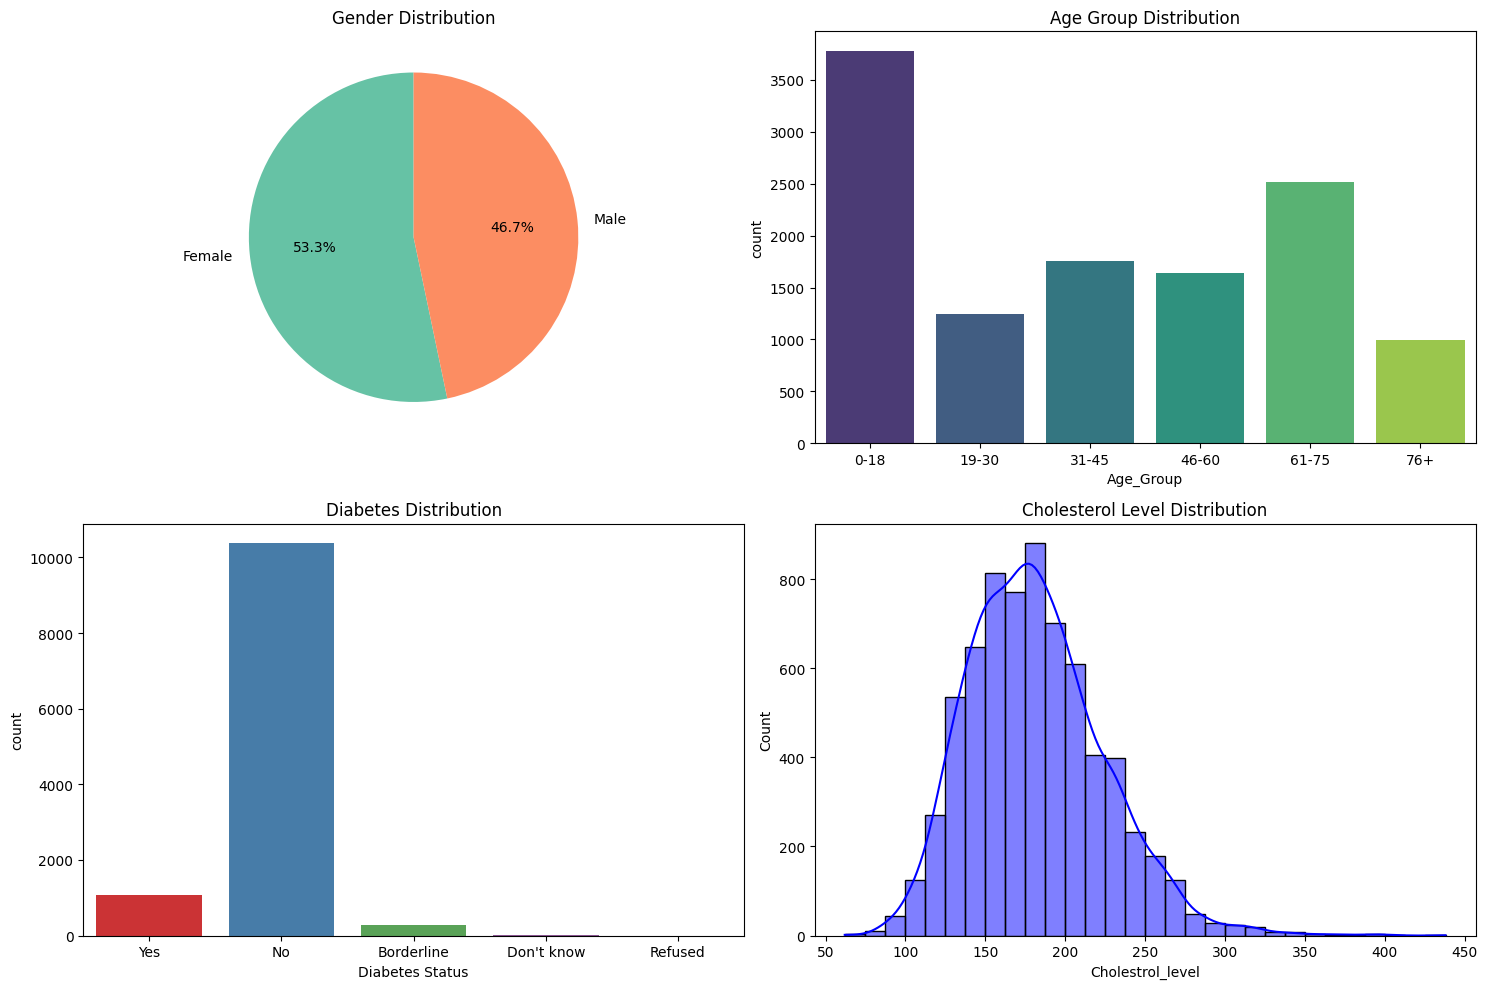

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = merged_df.copy()

# Map Gender
df['Gender'] = df['Gender'].map({1: 'Male', 2: 'Female'})

# Map Diabetes
diabetes_map = {
    1: 'Yes',
    2: 'No',
    3: 'Borderline',
    7: 'Refused',
    9: "Don't know"
}
df['Has_diabetes'] = df['Has_diabetes'].map(diabetes_map)

# Create Age Groups
bins = [0, 18, 30, 45, 60, 75, 100]
labels = ['0-18', '19-30', '31-45', '46-60', '61-75', '76+']
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(15,10))

# 1. Gender distribution (Pie Chart)
plt.subplot(2,2,1)
df['Gender'].value_counts().plot.pie(
    autopct='%1.1f%%', 
    startangle=90, 
    colors=sns.color_palette("Set2")
)
plt.title("Gender Distribution")
plt.ylabel("")

# 2. Age Group Distribution (Bar Chart)
plt.subplot(2,2,2)
sns.countplot(x='Age_Group', data=df, palette="viridis", order=labels)
plt.title("Age Group Distribution")

# 3. Diabetes Distribution (Bar Chart)
plt.subplot(2,2,3)
sns.countplot(x='Has_diabetes', data=df, palette="Set1",
              order=['Yes','No','Borderline',"Don't know",'Refused'])
plt.title("Diabetes Distribution")
plt.xlabel("Diabetes Status")

# 4. Cholesterol Distribution (Histogram + KDE)
plt.subplot(2,2,4)
sns.histplot(df['Cholestrol_level'], kde=True, color="blue", bins=30)
plt.title("Cholesterol Level Distribution")

plt.tight_layout()
plt.show()
